In [1]:
%matplotlib nbagg
%load_ext autoreload
%load_ext line_profiler

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse

In [8]:
%autoreload
import scipy.ndimage
import functools

from ptychography40.reconstruction.common import (
    diffraction_to_detector, wavelength,
    image_transformation_matrix, apply_matrix, fftshift_coords, ifftshift_coords
)
from libertem.corrections.coordinates import rotate_deg, flip_y
import libertem.api as lt
from libertem.executor.inline import InlineJobExecutor

In [102]:
source_shape = (7, 7)
target_shape = (7, 7)

In [103]:
# %lprun -f image_transformation_matrix image_transformation_matrix((1024, 1024), (256, 256), lambda x: x*4)

In [109]:
f = functools.partial(
    diffraction_to_detector,
    lamb=1,
    diffraction_shape=target_shape,
    pixel_size_real=1,
    pixel_size_detector=1/np.array(target_shape),
    cy=source_shape[0] / 2 - 1,
    cx=source_shape[1] / 2,
    flip_y=True,
    scan_rotation=0.
)

In [110]:
%autoreload
mat = image_transformation_matrix(
    source_shape=source_shape,
    target_shape=target_shape,
    affine_transformation=f,
)

In [111]:
data = np.linspace(0, 1, 4*np.prod(source_shape)).reshape((2, 2) + source_shape)
data[0, 0, 0, 0] = 1
data[0, 1, 0, -1] = 1
data[1, 1, -1, -1] = 1
data[1, 0, -1, 0] = 1

In [112]:
%autoreload
res = apply_matrix(data, mat, target_shape)

<IPython.core.display.Javascript object>


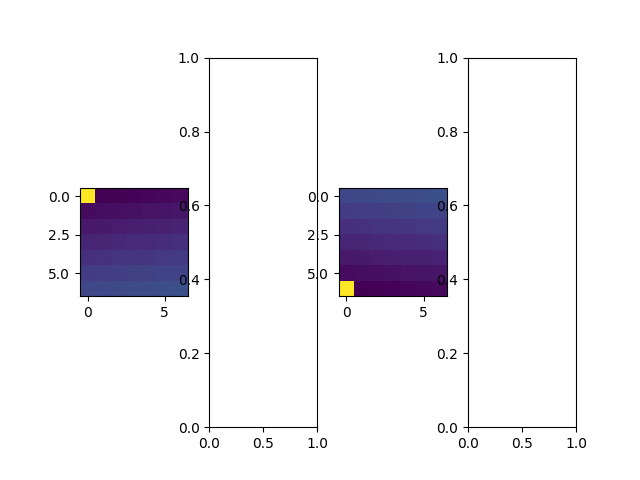

In [113]:
fig, axes = plt.subplots(1, 4)
axes[0].imshow(data[0, 0])
axes[2].imshow(res[0, 0])

In [ ]:
lt_ctx = lt.Context(InlineJobExecutor())

In [ ]:
ds = lt_ctx.load('memory', data=data, sig_dims=2)
transformed_ds = lt_ctx.load('memory', data=res, sig_dims=2)
com_a = lt_ctx.create_com_analysis(
    dataset=ds, mask_radius=np.inf, flip_y=False, scan_rotation=90.,
    cy=target_shape[0] / 2 - 0.5,
    cx=target_shape[1] / 2 - 0.5
)

com_res = lt_ctx.run(com_a)

trans_com_a = lt_ctx.create_com_analysis(
    dataset=transformed_ds, mask_radius=np.inf, flip_y=False, scan_rotation=0.,
    cy=target_shape[0] / 2 - 0.5,
    cx=target_shape[1] / 2 - 0.5
)
trans_com_res = lt_ctx.run(trans_com_a)

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(com_res.y.raw_data)
axes[0, 1].imshow(com_res.x.raw_data)
axes[1, 0].imshow(trans_com_res.y.raw_data)
axes[1, 1].imshow(trans_com_res.x.raw_data)